In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
df = pd.read_excel("SubhmanGill.xlsx")
df_copy = df.copy()
df.head()

,StartDate,Batting_partner,Partnership_runs,PartnerShipAvg,OutType,Dismissal_in_last5_matches,Opposition,Home/Away,Ground,StrikeRate(BowvsBatsman),...,Last5Avg,Bat1,PrevScore,Toss_Decision,Toss(W/L),MatchType(D/N),MatchStage,Captain,OppBowlerType,PitchReport
0,2018-04-14,Nithish Rana,15,15.0,Caught,0,v SRH,Home,Eden Gardens,33.33,...,0.0,3,0,1,L,N,League,DineshKarthik,Pace,Bowling
1,2018-04-16,Nithish Rana,15,15.0,Caught,0,v DC,Home,Eden Gardens,120.00,...,0.0,6,3,1,W,N,League,DineshKarthik,Spin,Batting
2,2018-04-21,Dinesh Karthik,26,26.0,NotOut,0,v PK,Home,Eden Gardens,175.00,...,0.0,14,6,1,W,D/N,League,DineshKarthik,NotOut,Bowling
3,2018-04-27,AndreRussel,64,64.0,RunOut,0,v DC,Away,Delhi,127.58,...,0.0,37,14,2,W,N,League,DineshKarthik,Runout,Batting
4,2018-04-29,Chris Lynn,5,5.0,NotOut,0,v RCB,Away,Bengaluru,250.00,...,0.0,5,37,2,W,N,League,DineshKarthik,NotOut,Balanced


## Dataset Description

The dataset contains match-level and performance-related attributes describing the
batting performance of Indian cricketer **Shubman Gill**. Each row represents a
single innings played by the player under different match conditions.

---

### Match & Context Attributes

- **StartDate**: Date on which the match was played  
- **Opposition**: Opponent team faced by the batsman  
- **Home/Away**: Indicates whether the match was played at home or away  
- **Ground**: Stadium or venue where the match was played  
- **MatchType (D/N)**: Specifies whether the match was a Day or Day/Night match  
- **MatchStage**: Stage of the match (League,Qualifier1,Qualifier2,Eliminator, Final)

---

### Partnership & Team Attributes

- **Batting_partner**: Batting partner during the innings  
- **Partnership_runs**: Total runs scored in the batting partnership  
- **PartnerShipAvg**: Average runs scored in partnerships with the given partner  
- **Captain**: Indicates the team captain during the match

---

### Batting Performance Attributes

- **Batting_pos**: Batting position of Shubman Gill in the innings  
- **BallsFaced**: Number of balls faced by the batsman  
- **StrikeRate (BowvsBatsman)**: Strike rate of the batsman against the bowler type faced  
- **Last5Avg**: Average runs scored in the last five matches (recent form)  
- **PrevScore**: Runs scored by the batsman in the previous match

---

### Dismissal & Match Outcome Attributes

- **OutType**: Mode of dismissal (caught, bowled, LBW, notout, runout, stumped)  
- **Dismissal_in_last5_matches**: Number of dismissals in the last five matches

---

### Toss & Match Decision Attributes

- **Toss_Decision**: Decision taken after winning the toss (bat-1or field-0)  
- **Toss (W/L)**: Indicates whether the toss was won or lost

---

### Opposition & Pitch Attributes

- **OppBowlerType**: Type of bowler faced (pace, spin , NotOut,Runout)  
- **PitchReport**: Description of pitch conditions (e.g., batting-friendly, bowler-friendly, balanced)

---

### Target Variable

- **Bat1**: Runs scored by Shubman Gill in the match  

This is a **continuous numerical variable** and serves as the **target variable**
for the supervised regression task.

---

### Problem Framing

- **Problem Type**: Supervised Machine Learning  
- **Task**: Regression  
- **Objective**: Predict the number of runs scored (`Bat1`) using match context,
  partnership details, and performance-related features.


##Intial Inspection

In [ ]:
df.shape

(86, 22)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86 entries, 0 to 85
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   StartDate                   86 non-null     datetime64[ns]
 1   Batting_partner             86 non-null     object        
 2   Partnership_runs            86 non-null     int64         
 3   PartnerShipAvg              86 non-null     float64       
 4   OutType                     86 non-null     object        
 5   Dismissal_in_last5_matches  86 non-null     int64         
 6   Opposition                  86 non-null     object        
 7   Home/Away                   86 non-null     object        
 8   Ground                      86 non-null     object        
 9   StrikeRate(BowvsBatsman)    86 non-null     float64       
 10  Batting_pos                 86 non-null     int64         
 11  BallsFaced                  86 non-null     int64         
 

In [ ]:
df.describe()

,StartDate,Partnership_runs,PartnerShipAvg,Dismissal_in_last5_matches,StrikeRate(BowvsBatsman),Batting_pos,BallsFaced,Last5Avg,Bat1,PrevScore,Toss_Decision
count,86,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,2022-04-24 18:58:36.279069696,52.755814,62.281545,3.988372,132.608023,2.616279,24.523256,34.683721,35.813953,36.186047,1.546512
min,2018-04-14 00:00:00,3.000000,5.000000,0.000000,25.000000,1.000000,2.000000,0.000000,1.000000,0.000000,1.000000
25%,2019-05-03 12:00:00,22.250000,37.525000,4.000000,100.000000,2.000000,9.000000,22.800000,9.000000,9.000000,1.000000
50%,2022-10-29 00:00:00,45.000000,63.350000,4.000000,135.030000,2.000000,20.000000,33.500000,30.500000,31.000000,2.000000
75%,2024-04-09 06:00:00,68.500000,83.228261,5.000000,166.170000,2.000000,38.000000,45.400000,56.750000,56.750000,2.000000
max,2025-05-30 00:00:00,210.000000,178.000000,5.000000,250.000000,7.000000,60.000000,83.000000,129.000000,129.000000,2.000000
std,NaN,41.494702,30.045261,1.241386,47.619331,1.617322,17.337974,18.056916,31.430413,31.375716,0.500752


In [ ]:
df.describe(include = 'object')

,Batting_partner,OutType,Opposition,Home/Away,Ground,Toss(W/L),MatchType(D/N),MatchStage,Captain,OppBowlerType,PitchReport
count,86,86,86,86,86,86,86,86,86,86,86
unique,19,6,9,3,16,2,2,5,4,4,3
top,Sai Sudharshan,Caught,v DC,Home,Ahmedabad,L,N,League,Hardik Pandya,Pace,Batting
freq,26,45,12,35,25,46,67,78,30,46,44


## Data Preprocessing

In [ ]:
df.isna().sum()

,0
StartDate,0
Batting_partner,0
Partnership_runs,0
PartnerShipAvg,0
OutType,0
Dismissal_in_last5_matches,0
Opposition,0
Home/Away,0
Ground,0
StrikeRate(BowvsBatsman),0


In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
Q1 = df["Bat1"].quantile(0.25)
Q3 = df["Bat1"].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df["Bat1"] < Q1 - 1.5*IQR) | (df["Bat1"] > Q3 + 1.5*IQR)]
outliers

,StartDate,Batting_partner,Partnership_runs,PartnerShipAvg,OutType,Dismissal_in_last5_matches,Opposition,Home/Away,Ground,StrikeRate(BowvsBatsman),...,Last5Avg,Bat1,PrevScore,Toss_Decision,Toss(W/L),MatchType(D/N),MatchStage,Captain,OppBowlerType,PitchReport
57,2023-05-26,Sai Sudharshan,138,104.0,Caught,3,v MI,Home,Ahmedabad,215.0,...,69.4,129,42,1,L,N,Qualifier2,Hardik Pandya,Pace,Batting




*   No Missing values to be handled.This improves data reliability and reduces preprocessing complexity.
*   Since Each Match is unique no duplicate rows are detected.
*   Outliers appear to be natural performance variations rather than data errors, so they should be retained to preserve real match behavior.



##Feature Engineering

In [ ]:
df["Bat1"].describe()


,Bat1
count,86.000000
mean,35.813953
std,31.430413
min,1.000000
25%,9.000000
50%,30.500000
75%,56.750000
max,129.000000


<Axes: >

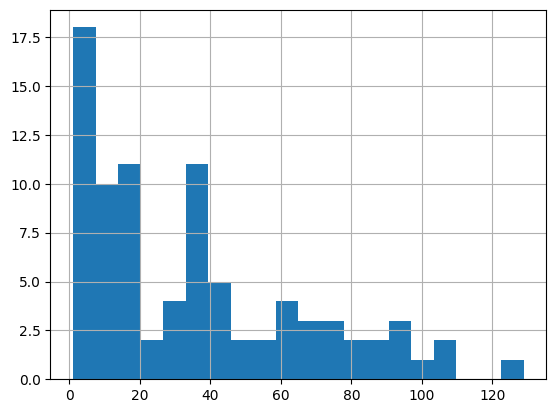

In [ ]:
df["Bat1"].hist(bins=20)


In [ ]:
df['Year'] = df['StartDate'].dt.year

In [ ]:
year_bat1 = df.groupby("Year").agg(
    Matches=("Bat1", "count"),
    Avg_Bat1=("Bat1", "mean"),
    Max_Bat1=("Bat1", "max"),
    Min_Bat1=("Bat1", "min")
).reset_index()

In [ ]:
year_bat1

,Year,Matches,Avg_Bat1,Max_Bat1,Min_Bat1
0,2018,10,20.300000,57,3
1,2019,13,22.769231,76,3
2,2021,6,22.000000,43,9
3,2022,14,34.500000,96,1
4,2023,16,55.625000,129,6
5,2024,12,35.500000,104,2
6,2025,15,43.333333,93,1


##YearWise Performance
* significant jump is observed from 2022 onwards.
* peak performance in 2023 with the highest average and maximum score

In [ ]:
df['Month'] = df['StartDate'].dt.month

In [ ]:
month_bat1 = df.groupby("Month").agg(
    Matches=("Bat1", "count"),
    Avg_Bat1=("Bat1", "mean"),
    Max_Bat1=("Bat1", "max"),
    Min_Bat1=("Bat1", "min")
).reset_index()

In [ ]:
month_bat1

,Month,Matches,Avg_Bat1,Max_Bat1,Min_Bat1
0,3,8,28.875000,63,4
1,4,47,31.702128,96,2
2,5,31,43.838710,129,1


##Seasonal Influence on Performance
* Matches played in May record the highest average runs and maximum scores

In [ ]:
df.drop(columns=['StartDate'], inplace=True)


##Final Preprocessing Decision on StartDate
The **StartDate** column was transformed into **Year** and **Month** to capture both **long-term performance trends and seasonal effects**. Since the **raw date** itself **does not add predictive value beyond these components**, the original StartDate column can be safely **dropped** after feature extraction to reduce model complexity.

##Cardinality Check

In [ ]:
cat_cols = df.select_dtypes(include="object").columns

In [ ]:
cardinality = pd.DataFrame({
    "Feature": cat_cols,
    "Unique_Values": [df[col].nunique() for col in cat_cols]
})
cardinality

,Feature,Unique_Values
0,Batting_partner,19
1,OutType,6
2,Opposition,9
3,Home/Away,3
4,Ground,16
5,Toss(W/L),2
6,MatchType(D/N),2
7,MatchStage,5
8,Captain,4
9,OppBowlerType,4


## Opposition

In [ ]:
opposition_impact = (
    df.groupby("Opposition")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std"
    )
    .sort_values("Avg_Bat1", ascending=False)
)

opposition_impact

,Matches,Avg_Bat1,Std_Bat1
Opposition,,,
v LSG,5,54.200000,28.734996
v KKR,4,46.250000,34.228400
v PK,10,43.300000,33.383462
v MI,12,40.083333,36.290390
v CSK,10,36.800000,30.983150
v SRH,11,33.818182,32.270166
v RR,12,32.583333,25.903521
v DC,12,31.083333,33.010903
v RCB,10,20.600000,30.815580


from matplotlib import pyplot as plt
opposition_impact['Matches'].plot(kind='hist', bins=20, title='Matches')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
opposition_impact['Avg_Bat1'].plot(kind='hist', bins=20, title='Avg_Bat1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
opposition_impact['Std_Bat1'].plot(kind='hist', bins=20, title='Std_Bat1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
opposition_impact.plot(kind='scatter', x='Matches', y='Avg_Bat1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
opposition_impact.plot(kind='scatter', x='Avg_Bat1', y='Std_Bat1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
opposition_impact['Matches'].plot(kind='line', figsize=(8, 4), title='Matches')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
opposition_impact['Avg_Bat1'].plot(kind='line', figsize=(8, 4), title='Avg_Bat1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
opposition_impact['Std_Bat1'].plot(kind='line', figsize=(8, 4), title='Std_Bat1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_0['Matches'].plot(kind='hist', bins=20, title='Matches')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Avg_Bat1'].plot(kind='hist', bins=20, title='Avg_Bat1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Std_Bat1'].plot(kind='hist', bins=20, title='Std_Bat1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3.plot(kind='scatter', x='Matches', y='Avg_Bat1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Avg_Bat1', y='Std_Bat1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5['Matches'].plot(kind='line', figsize=(8, 4), title='Matches')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_6['Avg_Bat1'].plot(kind='line', figsize=(8, 4), title='Avg_Bat1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_7['Std_Bat1'].plot(kind='line', figsize=(8, 4), title='Std_Bat1')
plt.gca().spines[['top', 'right']].set_visible(False)

Insights Drawn: Performances are


*   Consistent against RR where Avg 32.583333	> Std 25.903521,**Low Variability**
*   Inconsistent Against MI where Avg 40.083333 >	36.290390 ,**High variability**

*  Strong against **LSG,KKR,PK,MI** where **Avg>40**
* Weak Against **RCB, DC** where **Avg<Std**


In [ ]:
opposition_impact["Avg_Bat1"].max() - opposition_impact["Avg_Bat1"].min()

33.6

In [ ]:
df["Bat1"].std()

31.430413007676268

##Feature Retaining Decision


*  Opposition impact(33.6) = Difference of Average of High and Low Opposition

*  Global Standard Deviation of alll scores is 31.43
* opposition_impact > std so , this is strong feature for prediction





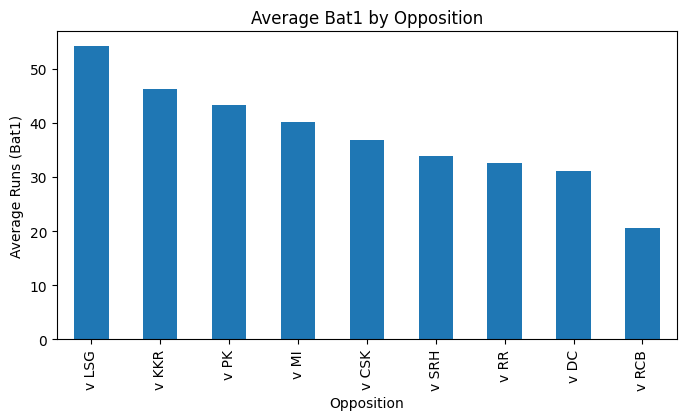

In [ ]:
opposition_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(8,4),
    title="Average Bat1 by Opposition"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()


##Captain impact on Bat1

In [ ]:
captain_impact = (
    df.groupby("Captain")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std"
    )
    .sort_values("Avg_Bat1", ascending=False)
)

captain_impact


,Matches,Avg_Bat1,Std_Bat1
Captain,,,
Hardik Pandya,30,45.766667,34.421007
SubhmanGill,27,39.851852,32.954168
Eion Morgan,6,22.000000,13.431307
DineshKarthik,23,21.695652,22.694482


## INSIGHTS
* Best under Hardik Pandya: The batter achieves the highest average (45.77) under Hardik Pandya’s captaincy, though with high variability, indicating both big scores and occasional failures.

* Moderate under Shubman Gill, Weak under Others: Performance is solid under Shubman Gill (Avg 39.85) but drops sharply under Eoin Morgan and Dinesh Karthik (Avg ≈21).

* Consistency vs Ceiling: Eoin Morgan’s captaincy shows the most consistent but lowest scoring pattern, while Hardik Pandya offers the highest scoring potential with greater volatility.

In [ ]:
captain_impact["Avg_Bat1"].max() - captain_impact["Avg_Bat1"].min()


24.071014492753623

In [ ]:
df["Bat1"].std()

31.430413007676268

## DECISION OF FEATURE RETENSION
* **Weak Signal vs Noise**: The captain-based average difference (24.07 runs) is smaller than the player’s natural score volatility (31.43), making the captain effect unreliable for single-match prediction.
* **Low-Priority Feature**: **Retainable in robust models (RF/GBM)** but a **primary removal candidate in simpler models** :due to limited data (only 4 captains) and potential sampling bias.

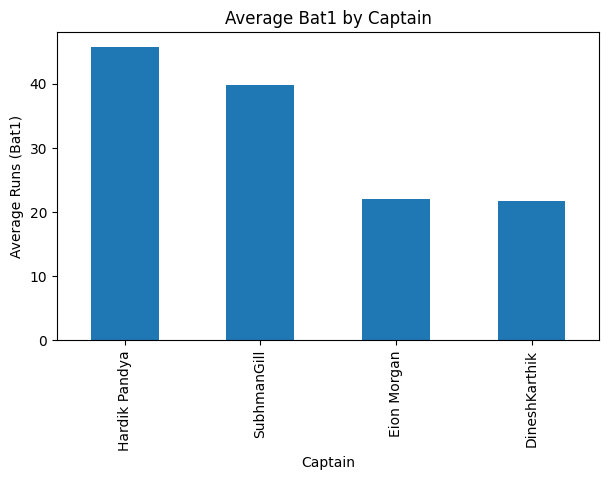

In [ ]:
captain_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(7,4),
    title="Average Bat1 by Captain"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()





*   
*   List item



**OutType**

In [ ]:
outtype_impact = (
    df.groupby("OutType")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std",
        Min_Bat1="min",
        Max_Bat1="max"
    )
    .sort_values("Avg_Bat1", ascending=False)
)

outtype_impact


,Matches,Avg_Bat1,Std_Bat1,Min_Bat1,Max_Bat1
OutType,,,,,
NotOut,15,48.866667,36.290232,3,104
Stumped,4,39.000000,25.806976,9,72
Caught,45,38.533333,32.728636,1,129
RunOut,7,25.571429,26.011902,4,76
Bowled,9,22.444444,20.329235,2,67
LBW,6,12.666667,10.481730,1,31


## INSIGHTS
* **Best When Set**: The batter scores highest when Not Out (Avg 48.87) and still posts strong scores when dismissed Caught or Stumped, indicating effective innings building once settled.

* **Weakness**: Direct dismissals by **Bowled** (22.44) and especially **LBW** (12.67, low variance) consistently result in low scores, highlighting vulnerability to straight, accurate bowling.

* **Moderate Risk via Run Outs**: Run outs produce middling returns (Avg 25.57), suggesting occasional innings truncation due to running risks.

In [ ]:
OutType_mean_diff = (
    outtype_impact["Avg_Bat1"].max() -
    outtype_impact["Avg_Bat1"].min()
)

OutType_mean_diff


36.2

## DECISION OF FEATURE RETENSION


*  OutType is a postoutcome value
*   Dismissal type depends on how many runs already scored

*  Causes target leakage
*  Used for Descriptive Analysis



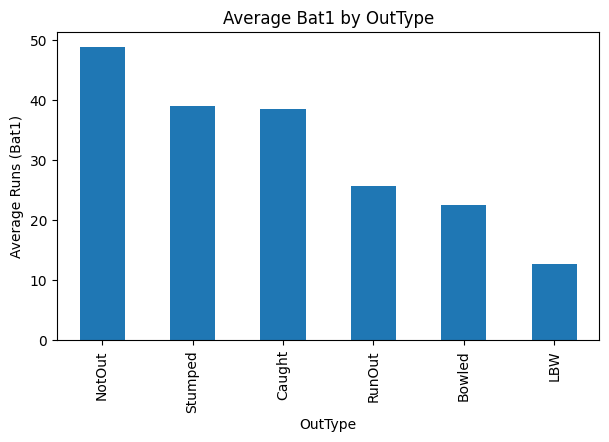

In [ ]:


outtype_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(7,4),
    title="Average Bat1 by OutType"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()


In [ ]:
partner_impact = (
    df.groupby("Batting_partner")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std",
        Min_Bat1="min",
        Max_Bat1="max"
    )
    .sort_values("Avg_Bat1", ascending=False)
)

partner_impact


,Matches,Avg_Bat1,Std_Bat1,Min_Bat1,Max_Bat1
Batting_partner,,,,,
DavidMiller,1,63.000000,NaN,63,63
WashingtonSundar,1,61.000000,NaN,61,61
VijayShankar,3,55.333333,49.003401,6,104
Sai Sudharshan,26,51.807692,38.044205,1,129
Hardik Pandya,7,44.142857,27.570688,6,84
JosButtler,1,43.000000,NaN,43,43
Rahul Tripathi,1,43.000000,NaN,43,43
DasunShanaka,1,42.000000,NaN,42,42
Robin Uthappa,2,35.500000,41.719300,6,65


from matplotlib import pyplot as plt
partner_impact['Matches'].plot(kind='hist', bins=20, title='Matches')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
partner_impact['Avg_Bat1'].plot(kind='hist', bins=20, title='Avg_Bat1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
partner_impact['Std_Bat1'].plot(kind='hist', bins=20, title='Std_Bat1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
partner_impact['Min_Bat1'].plot(kind='hist', bins=20, title='Min_Bat1')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
partner_impact.plot(kind='scatter', x='Matches', y='Avg_Bat1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
partner_impact.plot(kind='scatter', x='Avg_Bat1', y='Std_Bat1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
partner_impact.plot(kind='scatter', x='Std_Bat1', y='Min_Bat1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
partner_impact.plot(kind='scatter', x='Min_Bat1', y='Max_Bat1', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
partner_impact['Matches'].plot(kind='line', figsize=(8, 4), title='Matches')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
partner_impact['Avg_Bat1'].plot(kind='line', figsize=(8, 4), title='Avg_Bat1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
partner_impact['Std_Bat1'].plot(kind='line', figsize=(8, 4), title='Std_Bat1')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
partner_impact['Min_Bat1'].plot(kind='line', figsize=(8, 4), title='Min_Bat1')
plt.gca().spines[['top', 'right']].set_visible(False)



* High cardinality (19 partners)

* Many partners appear in 1–2 matches only

*  Confirms sparse representation




In [ ]:
partner_impact[["Matches", "Avg_Bat1"]]


,Matches,Avg_Bat1
Batting_partner,,
DavidMiller,1,63.000000
WashingtonSundar,1,61.000000
VijayShankar,3,55.333333
Sai Sudharshan,26,51.807692
Hardik Pandya,7,44.142857
JosButtler,1,43.000000
Rahul Tripathi,1,43.000000
DasunShanaka,1,42.000000
Robin Uthappa,2,35.500000


In [ ]:
partner_mean_diff = (
    partner_impact["Avg_Bat1"].max() -
    partner_impact["Avg_Bat1"].min()
)

partner_mean_diff


54.0

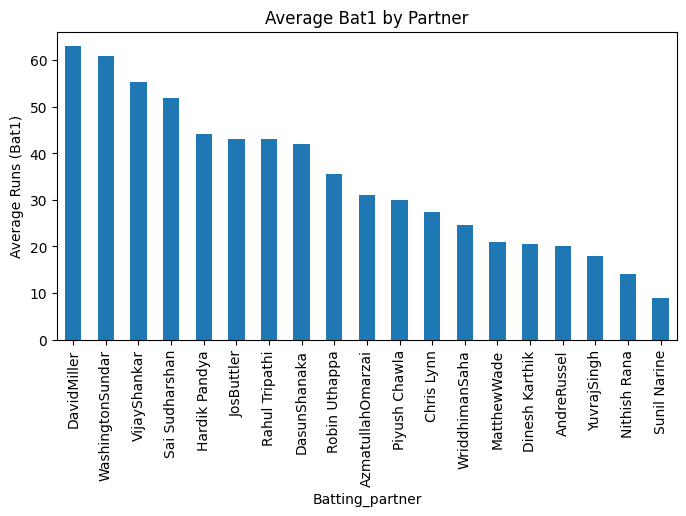

In [ ]:
partner_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(8,4),
    title="Average Bat1 by Partner"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()



*   High averages often correspond to low match counts

*   Here Subhman gill has good partnership with Sai Sudharshan as the number of matches played with him are high

*   But T20 team differ every year so can be used for descriptive analysis






In [ ]:
home_away_impact = (
    df.groupby("Home/Away")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std",
        Min_Bat1="min",
        Max_Bat1="max"
    )
)

home_away_impact


,Matches,Avg_Bat1,Std_Bat1,Min_Bat1,Max_Bat1
Home/Away,,,,,
Away,31,35.645161,31.759039,2,104
Home,35,41.142857,33.315023,2,129
Nuetral,20,26.750000,26.493048,1,96


In [ ]:
home_away_range = (
    home_away_impact["Avg_Bat1"].max() -
    home_away_impact["Avg_Bat1"].min()
)

home_away_range

14.392857142857146

In [ ]:
df["Bat1"].std()


31.430413007676268

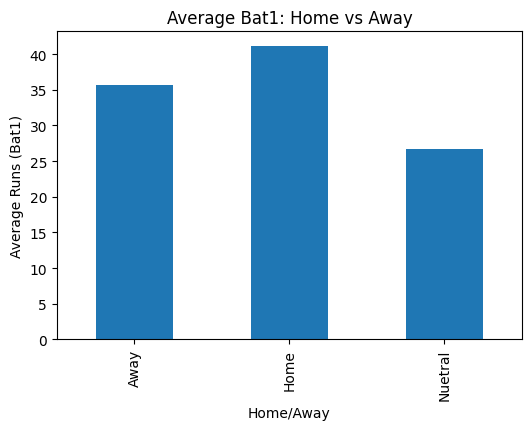

In [ ]:
home_away_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(6,4),
    title="Average Bat1: Home vs Away"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()



*   Difference between Home and Away averages is much smaller
*   So there is a overlap in score distributions.
*   Though the mean of bat1 at home was high but the difference is negligible



In [ ]:
df.groupby(["Ground", "Home/Away"])["Bat1"].mean().head(10)


Ground        Home/Away
Ahmedabad     Home         48.043478
              Nuetral      26.000000
Bengaluru     Away         25.600000
Brabourne     Away         52.000000
              Nuetral      63.500000
Chennai       Away         19.666667
              Nuetral      23.000000
DY Patil      Nuetral       9.000000
Delhi         Away         30.800000
Eden Gardens  Away         69.500000
Name: Bat1, dtype: float64



*   Same ground appears under both Home and Away

*   Ground-specific effects are stronger and more granular

*  Home/Away collapses information already captured by Ground

* Hence redundant for prediction.



In [ ]:
dn_impact = (
    df.groupby("MatchType(D/N)")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std",
        Min_Bat1="min",
        Max_Bat1="max"
    )
)

dn_impact


,Matches,Avg_Bat1,Std_Bat1,Min_Bat1,Max_Bat1
MatchType(D/N),,,,,
D/N,19,25.894737,22.367871,3,94
N,67,38.626866,33.157949,1,129


In [ ]:
dn_mean_diff = (
    dn_impact["Avg_Bat1"].max() -
    dn_impact["Avg_Bat1"].min()
)

dn_mean_diff


12.732128829536524

In [ ]:
df["Bat1"].std()


31.430413007676268

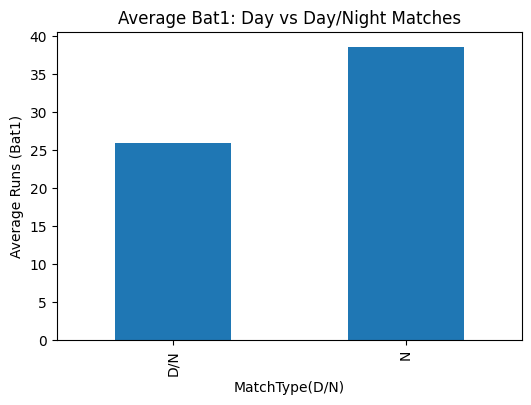

In [ ]:
dn_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(6,4),
    title="Average Bat1: Day vs Day/Night Matches"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()


In [ ]:
df[["MatchType(D/N)", "Bat1"]].head(10)


,MatchType(D/N),Bat1
0,N,3
1,N,6
2,D/N,14
3,N,37
4,N,5
5,N,57
6,D/N,7
7,D/N,16
8,D/N,28
9,N,30




*   Mean difference between Day and Day/Night is small
*   Overall Bat1 variability is much larger
*   MatchType does not meaningfully reduce prediction uncertainty




In [ ]:
toss_impact = (
    df.groupby("Toss(W/L)")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std",
        Min_Bat1="min",
        Max_Bat1="max"
    )
)

toss_impact


,Matches,Avg_Bat1,Std_Bat1,Min_Bat1,Max_Bat1
Toss(W/L),,,,,
L,46,37.608696,33.784598,1,129
W,40,33.750000,28.772984,1,104


In [ ]:
toss_mean_diff = (
    toss_impact["Avg_Bat1"].max() -
    toss_impact["Avg_Bat1"].min()
)

toss_mean_diff


3.858695652173914

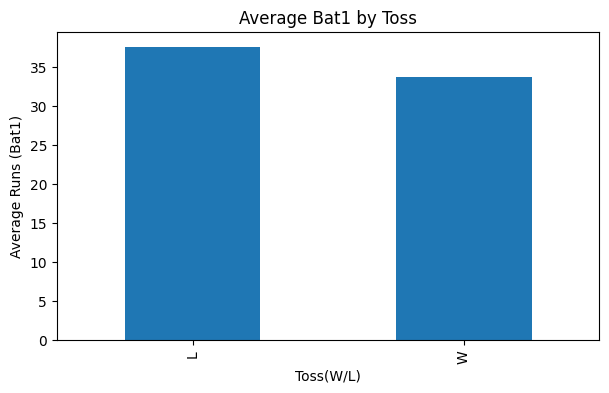

In [ ]:
toss_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(7,4),
    title="Average Bat1 by Toss"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()




*   Analyzed the impact of winning vs losing the toss on Bat1 using group-wise mean, standard deviation, and distribution overlap.

* Observed a very small difference in average runs (~3.86) compared to overall Bat1 variability (std ≈ 31.4), indicating weak predictive signal.

* Excluded from the final model as toss outcome does not meaningfully reduce prediction uncertainty and adds noise rather than information.




In [ ]:
MatchStage_impact = (
    df.groupby("MatchStage")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std",
        Min_Bat1="min",
        Max_Bat1="max"
    )
)

MatchStage_impact


,Matches,Avg_Bat1,Std_Bat1,Min_Bat1,Max_Bat1
MatchStage,,,,,
Eliminator,2,14.500000,19.091883,1,28
Final,2,42.000000,4.242641,39,45
League,78,35.012821,30.957656,1,104
Qualifier1,2,38.500000,4.949747,35,42
Qualifier2,2,79.500000,70.003571,30,129


In [ ]:
MatchStage_diff = (
    MatchStage_impact["Avg_Bat1"].max() -
    MatchStage_impact["Avg_Bat1"].min()
)

MatchStage_diff


65.0

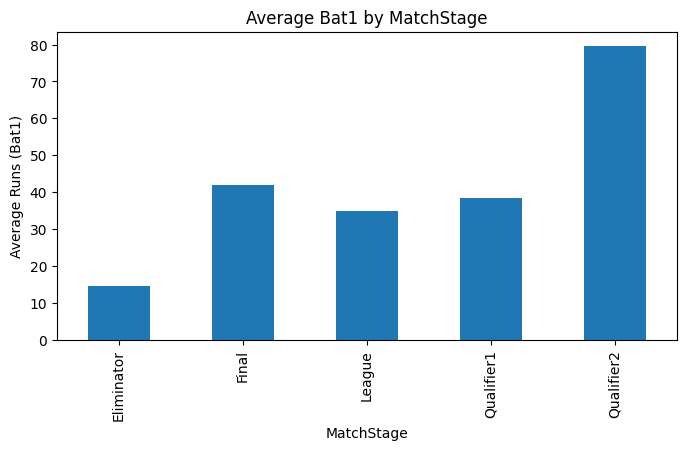

In [ ]:
MatchStage_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(8,4),
    title="Average Bat1 by MatchStage"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()


In [ ]:
bowling_impact = (
    df.groupby("OppBowlerType")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std",
        Min_Bat1="min",
        Max_Bat1="max"
    )
)

bowling_impact


,Matches,Avg_Bat1,Std_Bat1,Min_Bat1,Max_Bat1
OppBowlerType,,,,,
NotOut,15,48.866667,36.290232,3,104
Pace,46,32.956522,33.433820,1,129
Runout,7,25.571429,26.011902,4,76
Spin,18,36.222222,21.005757,6,84


In [ ]:
bowling_mean_diff = (
    bowling_impact["Avg_Bat1"].max() -
    bowling_impact["Avg_Bat1"].min()
)

bowling_mean_diff


23.295238095238094

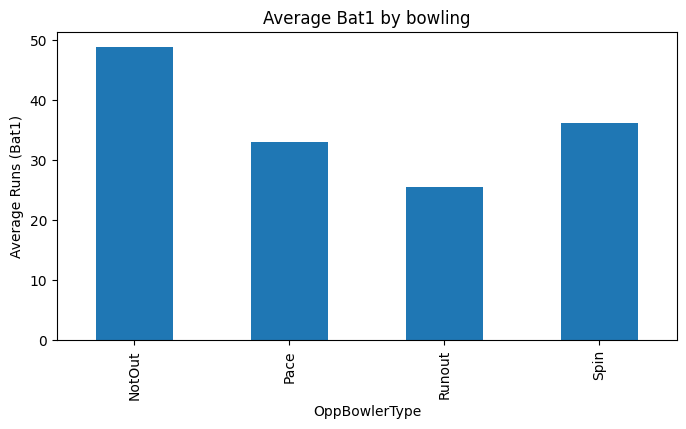

In [ ]:
bowling_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(8,4),
    title="Average Bat1 by bowling"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()


In [ ]:
pitch_impact = (
    df.groupby("PitchReport")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std",
        Min_Bat1="min",
        Max_Bat1="max"
    )
)

pitch_impact


,Matches,Avg_Bat1,Std_Bat1,Min_Bat1,Max_Bat1
PitchReport,,,,,
Balanced,31,30.516129,22.249900,1,84
Batting,44,44.681818,36.852170,1,129
Bowling,11,15.272727,13.221883,3,45


In [ ]:
pitch_mean_diff = (
    pitch_impact["Avg_Bat1"].max() -
    pitch_impact["Avg_Bat1"].min()
)

bowling_mean_diff


23.295238095238094

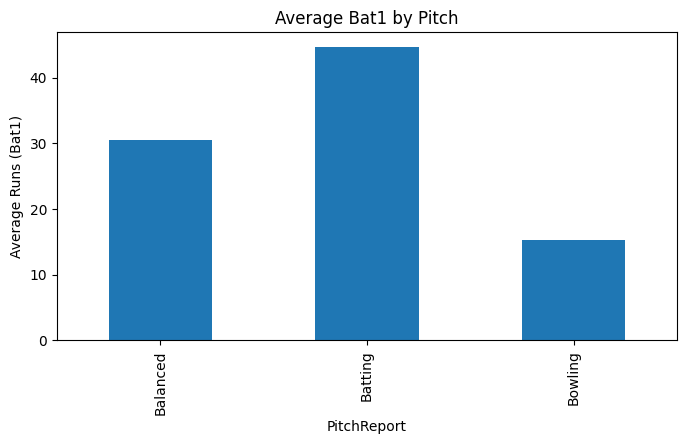

In [ ]:
pitch_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(8,4),
    title="Average Bat1 by Pitch"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()


In [ ]:
ground_impact = (
    df.groupby("Ground")["Bat1"]
    .agg(
        Matches="count",
        Avg_Bat1="mean",
        Std_Bat1="std",
        Min_Bat1="min",
        Max_Bat1="max"
    )
)

ground_impact

,Matches,Avg_Bat1,Std_Bat1,Min_Bat1,Max_Bat1
Ground,,,,,
Ahmedabad,25,46.280000,34.979184,2,129
Bengaluru,5,25.600000,44.082876,2,104
Brabourne,3,59.666667,33.171273,31,96
Chennai,6,21.333333,13.662601,8,42
DY Patil,4,9.000000,2.828427,7,13
Delhi,5,30.800000,37.157772,4,93
Eden Gardens,15,33.933333,27.327293,3,90
Hyderabad,2,32.000000,41.012193,3,61
Indore,1,16.000000,NaN,16,16


In [ ]:
ground_mean_diff = (
    ground_impact["Avg_Bat1"].max() -
    ground_impact["Avg_Bat1"].min()
)

ground_mean_diff


72.5

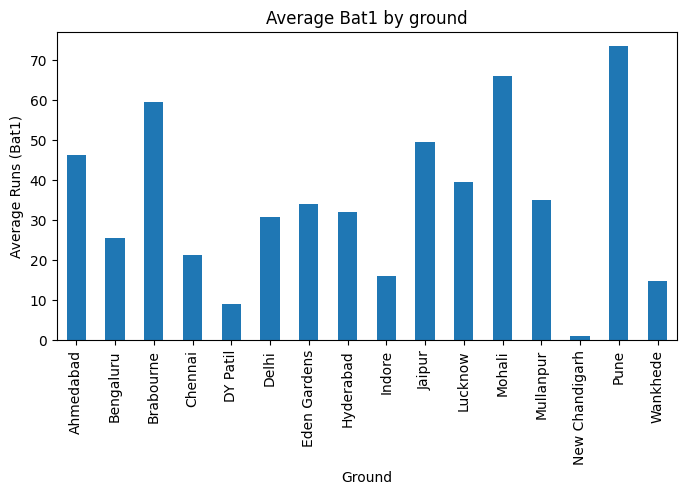

In [ ]:
ground_impact["Avg_Bat1"].plot(
    kind="bar",
    figsize=(8,4),
    title="Average Bat1 by ground"
)

plt.ylabel("Average Runs (Bat1)")
plt.show()


##Numerical Features Analysis

1.   Balls Faced
2.   PartnershipRuns
3.   PartnershipAvg
4.   prevScore
5.   Last5Avg
6.   BattingPosition
7.   Strikerate
8.   tossDecision
9. Dismissal in last5 Matches




In [ ]:
target = "Bat1"

# Separate features
num_cols = df.select_dtypes(include=["int64", "float64"]).columns.drop(target)
cat_cols = df.select_dtypes(include="object").columns

# Numerical correlations
num_corr = (
    df[num_cols.tolist() + [target]]
    .corr()[target]
    .drop(target)
    .sort_values(ascending=False)
    .reset_index()
    .rename(columns={"index": "Feature", target: "Correlation_with_Bat1"})
)

# Categorical impact via mean range
cat_impact = []
for col in cat_cols:
    grp = df.groupby(col)[target].mean()
    cat_impact.append({
        "Feature": col,
        "Unique_Values": df[col].nunique(),
        "Min_Mean_Bat1": round(grp.min(), 2),
        "Max_Mean_Bat1": round(grp.max(), 2),
        "Range_of_Means": round(grp.max() - grp.min(), 2)
    })

cat_impact_df = pd.DataFrame(cat_impact).sort_values("Range_of_Means", ascending=False)

num_corr, cat_impact_df

(                      Feature  Correlation_with_Bat1
 0                  BallsFaced               0.949795
 1            Partnership_runs               0.833438
 2    StrikeRate(BowvsBatsman)               0.577440
 3              PartnerShipAvg               0.415584
 4  Dismissal_in_last5_matches               0.229706
 5                    Last5Avg               0.160797
 6                   PrevScore               0.148312
 7               Toss_Decision              -0.087648
 8                 Batting_pos              -0.322194,
             Feature  Unique_Values  Min_Mean_Bat1  Max_Mean_Bat1  \
 4            Ground             16           1.00          73.50   
 7        MatchStage              5          14.50          79.50   
 0   Batting_partner             19           9.00          63.00   
 1           OutType              6          12.67          48.87   
 2        Opposition              9          20.60          54.20   
 10      PitchReport              3          

In [ ]:
# Columns identified for dropping
cols_to_drop = [
    "Batting_pos",
    "Toss_Decision",
    "Captain",
    "OutType",
    "Home/Away",
    "MatchType(D/N)",
    "Toss(W/L)",
    "Batting_partner"
]

# Drop columns
df = df.drop(columns=cols_to_drop)


In [ ]:
num_corr_after = (
    df.select_dtypes(include=["int64", "float64"])
    .corr()[target]
    .drop(target)
    .sort_values(ascending=False)
)

num_corr_after

,Bat1
BallsFaced,0.949795
Partnership_runs,0.833438
StrikeRate(BowvsBatsman),0.577440
PartnerShipAvg,0.415584
Dismissal_in_last5_matches,0.229706
Last5Avg,0.160797
PrevScore,0.148312
Toss_Decision,-0.087648
Batting_pos,-0.322194


## Model Selection, Model Training and Model Evaluation

###Linear Regression

In [ ]:

# Target
y = df["Bat1"]
X = df.drop(columns=["Bat1"])

# ---------------- CARDINALITY-BASED ENCODING ----------------

# Categorical columns
cat_cols = X.select_dtypes(include="object").columns.tolist()

# Cardinality mapping
cardinality = {col: X[col].nunique() for col in cat_cols}

# Apply rules
low_card = [c for c, v in cardinality.items() if v <= 5]
mid_card = [c for c, v in cardinality.items() if 5 < v <= 15]
high_card = [c for c, v in cardinality.items() if v > 15]

# Frequency encoding for high-cardinality
X_encoded = X.copy()
for col in high_card:
    freq = X_encoded[col].value_counts(normalize=True)
    X_encoded[col] = X_encoded[col].map(freq)

# Updated categorical columns (low + mid only for OHE)
ohe_cols = low_card + mid_card

# Numerical columns
num_cols = X_encoded.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols),
        ("num", "passthrough", num_cols)
    ]
)

# Linear Regression model
lr = LinearRegression()

# Pipeline
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", lr)
])

# ---------------- K-FOLD CROSS VALIDATION ----------------
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_encoded, y, cv=kf, scoring="r2")

cv_scores, cv_scores.mean(), cv_scores.std()


(array([0.94392922, 0.86421581, 0.92799257, 0.91212616, 0.9491968 ]),
 np.float64(0.9194921133756511),
 np.float64(0.030533671626975782))

###Ridge Regression

In [ ]:
# Target
y = df["Bat1"]
X = df.drop(columns=["Bat1"])

# Categorical columns
cat_cols = X.select_dtypes(include="object").columns.tolist()

# Cardinality
cardinality = {col: X[col].nunique() for col in cat_cols}

low_card = [c for c, v in cardinality.items() if v <= 5]
mid_card = [c for c, v in cardinality.items() if 5 < v <= 15]
high_card = [c for c, v in cardinality.items() if v > 15]

# Frequency encoding for high-cardinality
X_encoded = X.copy()
for col in high_card:
    freq = X_encoded[col].value_counts(normalize=True)
    X_encoded[col] = X_encoded[col].map(freq)

# Columns for One-Hot Encoding
ohe_cols = low_card + mid_card

# Numerical columns
num_cols = X_encoded.select_dtypes(include=["int64", "float64"]).columns.tolist()

# Preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ("ohe", OneHotEncoder(drop="first", handle_unknown="ignore"), ohe_cols),
        ("num", StandardScaler(), num_cols)
    ]
)

# Ridge Regression
ridge = Ridge(alpha=1.0)

pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", ridge)
])

# 5-Fold CV
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(pipeline, X_encoded, y, cv=kf, scoring="r2")

cv_r2, cv_r2.mean(), cv_r2.std()

(array([0.94939474, 0.90486857, 0.94326611, 0.9168232 , 0.9508491 ]),
 np.float64(0.9330403429711197),
 np.float64(0.018685975936883918))

### Random Forest

In [ ]:
y = df["Bat1"]
X = df.drop(columns=["Bat1"])

# Identify categorical & numerical columns
cat_cols = X.select_dtypes(include="object").columns.tolist()
num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()

# One-hot encode ONLY low & mid cardinality (trees can handle it better)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
        ("num", "passthrough", num_cols)
    ]
)

# Random Forest model
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=8,
    random_state=42,
    n_jobs=-1
)

# Pipeline
pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", rf)
])

# 5-Fold Cross Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_r2 = cross_val_score(pipeline, X, y, cv=kf, scoring="r2")

cv_r2, cv_r2.mean(), cv_r2.std()

(array([0.96669035, 0.9481367 , 0.96718985, 0.93263439, 0.93910516]),
 np.float64(0.9507512913012715),
 np.float64(0.014106524672821384))